In [216]:
%%capture
!pip install plotly
!pip install alpha_vantage
!pip install quandl
!pip install --upgrade plotly
!pip install --upgrade notebook
!pip install arch
!pip install cvxpy
!pip install fredapi
!pip install mpl_toolkits
%run config.py

In [217]:
from alpha_vantage.timeseries import TimeSeries
import quandl
import matplotlib.pyplot as plt
import config 
import plotly.express as px
import pandas as pd
import os
import numpy as np
import datetime
import plotly.io as pio
pio.renderers.default = 'notebook'
from arch import arch_model
import cvxpy as cp
from fredapi import Fred
def write_date_to_file(file_path):
    today_date = datetime.datetime.today().strftime("%Y-%m-%d")
    with open(file_path, "w") as file:
        file.write(today_date)

# Function to read the date from the file
def read_date_from_file(file_path):
    with open(file_path, "r") as file:
        saved_date = file.read().strip()
    return saved_date


In [218]:
#### Get inflation data

def get_macro_data(series_id,name):
    fred = Fred(api_key= api_fred)
    
    macro_data = fred.get_series(series_id)
    macro_data = pd.DataFrame(macro_data).reset_index()
    macro_data.columns=['date',name]
    macro_data['date'] = pd.to_datetime(macro_data['date'],format = '%Y-%m-%d')
    macro_data.set_index('date',inplace=True)
    macro_data = macro_data.resample('D').interpolate().reset_index()
    macro_data[name+'_growth'] = macro_data[name].pct_change()
    macro_data[name + '_first_diff'] = macro_data[name].diff()
    return macro_data

df_cpi = get_macro_data('CPIAUCSL','cpi')
df_ur = get_macro_data('UNRATE','unemp')
df_int = get_macro_data('T10Y2Y','intrate')


In [219]:
### Fetch stock data

date_path = 'last_fetched.txt'
subfolder='data/'
list_symbols = ['AAPL','AMZN','TSLA']
rewrite_data_force = False

    #### Check if the data was recently updated.
ts = TimeSeries(key=config.api_key, output_format='pandas')

if not os.path.exists(date_path):
    write_date_to_file(date_path)
saved_date = read_date_from_file(date_path)
today_date = datetime.datetime.today().strftime("%Y-%m-%d")
# Compare the saved date and today's date
if saved_date < today_date:
    rewrite_data = True
    write_date_to_file(date_path)
else:
    rewrite_data = False


common_dates = pd.date_range(start='2011-01-01', end='2023-10-01', freq='D')

df_returns = pd.DataFrame({'date': common_dates})


for symbol in list_symbols:    
    data_path = os.path.join(subfolder, 'portfolio_data_' + symbol.replace('.','_') + '.parquet')
    print("rewriting data? : ",((not os.path.exists(data_path)) | rewrite_data ))
    global data
    if ((not os.path.exists(data_path)) | rewrite_data | rewrite_data_force):
        data, _ = ts.get_weekly_adjusted(symbol=symbol)
        data.to_parquet(data_path)
    else:
        data = pd.read_parquet(data_path)


    data = data.sort_values(by='date')
    data = data.resample('D').interpolate().reset_index()
    data = data[['date','5. adjusted close']]
    # Rename the '5. adjusted close' column to be symbol-specific
    data.rename(columns={'5. adjusted close': 'adj_close_' + symbol}, inplace=True)

    df_returns = pd.merge(df_returns, data, on='date', how='left')

    colname = 'adj_close_'+symbol
    df_returns['return_'+symbol] = df_returns[colname].pct_change()


df_final = pd.merge(df_returns,df_cpi,on = 'date',how='left').dropna()
df_final = pd.merge(df_final,df_ur,on = 'date',how='left').dropna()
df_final = pd.merge(df_final,df_int,on = 'date',how='left').dropna()

rewriting data? :  False
rewriting data? :  False
rewriting data? :  False


In [220]:
return_cols = [col for col in df_final.columns if 'return' in col]
macro_vars = ['cpi_first_diff','unemp_first_diff','intrate_first_diff']
var_cols = return_cols + macro_vars


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Oct, 2023
Time:                     12:52:06
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -61.8777
Nobs:                     4618.00    HQIC:                  -62.0132
Log likelihood:           104193.    FPE:                1.08650e-27
AIC:                     -62.0868    Det(Omega_mle):     1.05187e-27
--------------------------------------------------------------------
Results for equation return_AAPL
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000115         0.000055            2.106           0.035
L1.return_AAPL                0.898209         0.016845           53.323           0.000
L1.return_AMZN        

C:\Users\mohda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



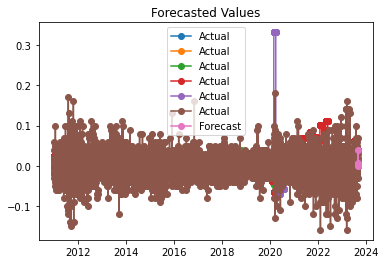

In [221]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

p = 4
data = df_final[var_cols]
model = VAR(data)
results = model.fit(p)

coefficients = results.coefs


forecast = results.forecast(data.values[-p:], steps=1)


print(results.summary())

actual = data.loc[-p:]
forecasted = forecast[0]
time_index = df_final['date'] 
plt.plot(time_index, actual, label='Actual', marker='o')
last_timestamp = time_index.iloc[-1] 
forecast_timestamp = last_timestamp + pd.DateOffset(days=1)

forecasted_timestamps = [forecast_timestamp + pd.DateOffset(days=i) for i in range(len(forecasted))]

plt.plot(forecasted_timestamps, forecasted, label='Forecast', marker='o')
plt.legend()
plt.title('Forecasted Values')
plt.show()

In [222]:
forecast_timestamp

Timestamp('2023-09-02 00:00:00')

In [223]:
forecasted

array([7.15096168e-03, 4.37775843e-03, 3.65844983e-03, 3.85974020e-02,
       5.22126205e-05, 4.48892991e-03])

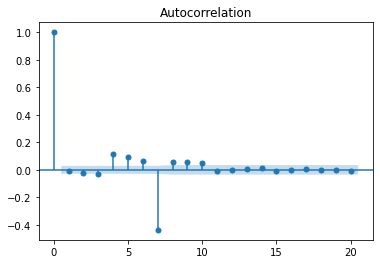

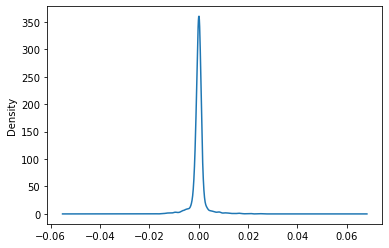

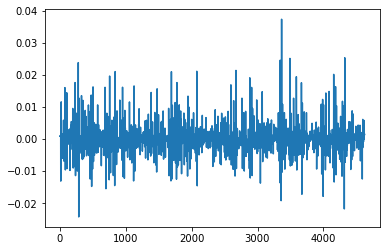

In [224]:
import matplotlib.pyplot as plt

col_plot = 'return_AAPL'
sm.graphics.tsa.plot_acf(results.resid[col_plot], lags=20)  
plt.show()

results.resid[col_plot].plot(kind='kde')  
plt.show()

results.resid[col_plot].plot()  
plt.show()

In [230]:
quantiles = [0, 1/3, 2/3, 1]
for i in ['unemp','cpi_growth','intrate']:
    buckets = pd.qcut(df_final[i], quantiles, labels=['low', 'medium', 'hi'])
    df_final['buckets_'+i] = buckets


In [226]:
df_cpi

,date,cpi,cpi_growth,cpi_first_diff
0,1947-01-01,21.480000,NaN,NaN
1,1947-01-02,21.484516,0.000210,0.004516
2,1947-01-03,21.489032,0.000210,0.004516
3,1947-01-04,21.493548,0.000210,0.004516
4,1947-01-05,21.498065,0.000210,0.004516
...,...,...,...,...
27998,2023-08-28,307.324613,0.000127,0.039097
27999,2023-08-29,307.363710,0.000127,0.039097
28000,2023-08-30,307.402806,0.000127,0.039097
28001,2023-08-31,307.441903,0.000127,0.039097


In [227]:
fred.search('interest')

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
FEDFUNDS,FEDFUNDS,2023-10-22,2023-10-22,Federal Funds Effective Rate,1954-07-01,2023-09-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2023-10-02 15:17:03-05:00,97,Averages of daily figures. For additional hi...
DFF,DFF,2023-10-22,2023-10-22,Federal Funds Effective Rate,1954-07-01,2023-10-19,"Daily, 7-Day",D,Percent,%,Not Seasonally Adjusted,NSA,2023-10-20 15:26:02-05:00,85,For additional historical federal funds rate d...
T10Y2Y,T10Y2Y,2023-10-22,2023-10-22,10-Year Treasury Constant Maturity Minus 2-Yea...,1976-06-01,2023-10-20,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2023-10-20 16:02:13-05:00,100,"Starting with the update on June 21, 2019, the..."
FF,FF,2023-10-22,2023-10-22,Federal Funds Effective Rate,1954-07-07,2023-10-18,"Weekly, Ending Wednesday",W,Percent,%,Not Seasonally Adjusted,NSA,2023-10-19 15:27:02-05:00,61,Averages of daily figures. For additional hi...
MORTGAGE30US,MORTGAGE30US,2023-10-22,2023-10-22,30-Year Fixed Rate Mortgage Average in the Uni...,1971-04-02,2023-10-19,"Weekly, Ending Thursday",W,Percent,%,Not Seasonally Adjusted,NSA,2023-10-19 11:06:03-05:00,99,"On November 17, 2022, Freddie Mac changed the ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDEI01MEA156NWDB,DDEI01MEA156NWDB,2023-10-22,2023-10-22,Bank's Net Interest Margin for Montenegro,2004-01-01,2019-01-01,Annual,A,Percent,%,Not Seasonally Adjusted,NSA,2022-08-04 09:49:59-05:00,1,Accounting value of bank's net interest revenu...
DDEI01DOA156NWDB,DDEI01DOA156NWDB,2023-10-22,2023-10-22,Bank's Net Interest Margin for Dominican Republic,2000-01-01,2020-01-01,Annual,A,Percent,%,Not Seasonally Adjusted,NSA,2022-08-04 09:50:03-05:00,1,Accounting value of bank's net interest revenu...
DDEI01KNA156NWDB,DDEI01KNA156NWDB,2023-10-22,2023-10-22,Bank's Net Interest Margin for Saint Kitts and...,1996-01-01,2016-01-01,Annual,A,Percent,%,Not Seasonally Adjusted,NSA,2018-09-21 11:24:30-05:00,1,Accounting value of bank's net interest revenu...


In [231]:
df_final

,date,adj_close_AAPL,return_AAPL,adj_close_AMZN,return_AMZN,adj_close_TSLA,return_TSLA,cpi,cpi_growth,cpi_first_diff,unemp,unemp_growth,unemp_first_diff,intrate,intrate_growth,intrate_first_diff,buckets_unemp,buckets_cpi_growth,buckets_intrate
0,2011-01-02,9.894329,0.005970,9.078429,0.004338,1.805986,0.008568,221.209935,0.000104,0.022935,9.096774,-0.000354,-0.003226,2.73,0.007380,0.02,hi,hi,hi
1,2011-01-03,9.953043,0.005934,9.117643,0.004320,1.821329,0.008496,221.232871,0.000104,0.022935,9.093548,-0.000355,-0.003226,2.75,0.007326,0.02,hi,hi,hi
2,2011-01-04,10.011757,0.005899,9.156857,0.004301,1.836671,0.008424,221.255806,0.000104,0.022935,9.090323,-0.000355,-0.003226,2.73,-0.007273,-0.02,hi,hi,hi
3,2011-01-05,10.070471,0.005865,9.196071,0.004283,1.852014,0.008354,221.278742,0.000104,0.022935,9.087097,-0.000355,-0.003226,2.79,0.021978,0.06,hi,hi,hi
4,2011-01-06,10.129186,0.005830,9.235286,0.004264,1.867357,0.008284,221.301677,0.000104,0.022935,9.083871,-0.000355,-0.003226,2.76,-0.010753,-0.03,hi,hi,hi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621,2023-08-28,183.260000,0.008530,135.342857,0.005156,241.341429,0.003815,307.324613,0.000127,0.039097,3.800000,0.000000,0.000000,-0.78,0.000000,0.00,low,hi,low
4622,2023-08-29,184.810000,0.008458,136.037143,0.005130,242.258571,0.003800,307.363710,0.000127,0.039097,3.800000,0.000000,0.000000,-0.75,-0.038462,0.03,low,hi,low
4623,2023-08-30,186.360000,0.008387,136.731429,0.005104,243.175714,0.003786,307.402806,0.000127,0.039097,3.800000,0.000000,0.000000,-0.78,0.040000,-0.03,low,hi,low
4624,2023-08-31,187.910000,0.008317,137.425714,0.005078,244.092857,0.003772,307.441903,0.000127,0.039097,3.800000,0.000000,0.000000,-0.76,-0.025641,0.02,low,hi,low


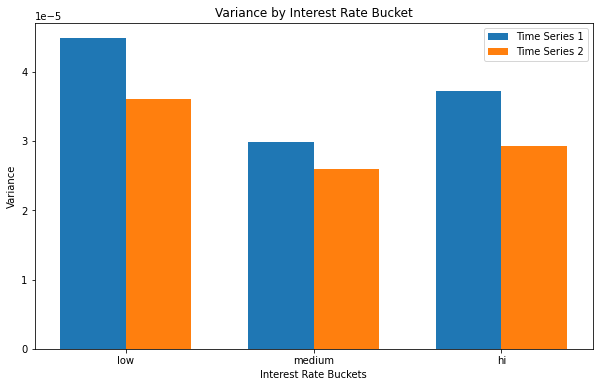

In [241]:
import seaborn as sns
unique_buckets_unemp = df_final['buckets_unemp'].unique()
unique_buckets_cpi_growth = df_final['buckets_cpi_growth'].unique()
unique_buckets_intrate = df_final['buckets_intrate'].unique()

variance_data = df_final.groupby('buckets_intrate').var()

plt.figure(figsize=(10, 6))

bar_width = 0.35
index = range(len(variance_data))
bar1 = plt.bar(index, variance_data['return_AMZN'], bar_width, label='Time Series 1')
bar2 = plt.bar([i + bar_width for i in index], variance_data['return_AAPL'], bar_width, label='Time Series 2')

plt.xlabel('Interest Rate Buckets')
plt.ylabel('Variance')
plt.title('Variance by Interest Rate Bucket')
plt.xticks([i + bar_width / 2 for i in index], variance_data.index)
plt.legend()

plt.show()